In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os 
import pickle
import re
import joblib
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
from sklearn.metrics import confusion_matrix

In [2]:
#funciones de apoyo 
def load_df(path):
    """
    Recibe el path en donde se encuentra el pickle que se quiere volver a cargar.
    """
    # Recuperar el pickle
    pkl = pickle.load(open(path, "rb"))

    return pkl


def load_features(path):
    """
    Cargar pickle que se generó durante la transformación
    :param path: Path donde se encuentra el pickle
    :return:
    """
    print("Opening feature engineering pickle from output path")
    output_path = os.path.join(path, "output", "fe_df.pkl")

    # Recuperar el pickle
    incidentes_pkl = load_df(output_path)
    print("Feature Engineering pickle successfully retrieved.")
 
    return incidentes_pkl

def filter_drop(df):
    """
    Función para elegir variables relevantes y tirar los datos vacíos de latitud y longitud. 
    :param df: dataframe a transformar
    :return df: dataframe con las columnas relevantes y sin datos nulos
    """
    print("Dropping columns and Nan's (don't worry, it'll be ok)")
    #solo por seguridad nos aseguramos que estén ordenadas (aunque ya están)
    df = df.sort_values(by=["año_creacion", "mes_creacion", "dia_creacion",
                            "hora_simple"])
    return df.drop(columns=["año_creacion", "mes_creacion", "dia_creacion"]).dropna()

def train_test_split(df, test_size=.70):
    """
    Función para separar en train y test el dataframe.
    Es un poco manual porque son datos temporales -- y no queremos problemas.
    :param df: dataframe a separar en train y test
    :param test_size: fracción entre 0 y 1 que nos permita separar el dataframe. El default es .70
    :return X_train, y_train, X_test, y_test: los 4 fantásticos. 
    """
    if test_size <= 0 or test_size >= 1:
        raise ValueError("Test Size Error. Pick a test size between 0 and 1.")

    #separar features y labels
    print("Performing train test split")
    X = df.drop(columns=["label"]).copy()
    Y = df.label.copy()
    lim = round(df.shape[0] * test_size)  # 70% de train
    X_train, X_test = X[:lim], X[lim:]
    y_train, y_test = Y[:lim], Y[lim:]
    print("Train test split successfully performed")
    return X_train, y_train, X_test, y_test

# Análisis de Sesgo con Aequitas.

El propósito de este notebook es realizar un análisis de sesgo de nuestro modelo utilizando el _framework_ de Aequitas. 

#### Métricas elegidas:

Con base en en el ["Fairness Tree"](https://github.com/ITAM-DS/introduction_to_ds_2020/blob/master/8_audit_bias.md) de Aequitas, decidimos elegir las siguientes tres métricas:

* PPR (dado que nos interesa medir la proporción de llamadas que atendemos por colonia)
* FOR Parity (dado que nos interesa apoyar a quienes no estén recibiendo apoyo)
* FNR Parity (dado que nos interesa apoyar con ambulancias a quienes más lo necesiten)

#### Setup del dataframe. 

Aequitas necesita un dataframe con cierto número de columnas. Haremos eso aquí. 

Pero primero recuperaremos el modelo. 

In [3]:
def load_selected_model(path):
    """
    Function to retrieve the model obtained using the magic loop.
    :param path: path to your model
    :param model: name of your model
    :return model: magic model 
    """
    modelo = joblib.load(path) 
    #lo hice con joblib;
    return modelo

In [4]:
#JOBLIB:
PATH = '/Users/Leo/Documents/MCD/1o/IDS/Proyectos/proyecto1/Notebooks/finalized_model.sav'
model = load_selected_model(PATH)

#PICKLE:
#model = pickle.load(open("logistic_regression_VF.pkl", "rb"))

In [5]:
#model = gs.best_estimator_
model

LogisticRegression(solver='sag')

In [6]:
#cargando X_test y y_test
X_test = pickle.load(open("X_test_diciembre4.pkl", "rb"))
y_test = pickle.load(open("y_test_diciembre4.pkl", "rb"))

Ahora podemos predecir en el conjunto de entrenamiento y generar las etiquetas. 

In [7]:
predicted_labels = model.predict(X_test)
predicted_scores = model.predict_proba(X_test)
predicted_probs = pd.DataFrame(predicted_scores, columns=["probability_0", "probability_1"])
predicted_probs.head()

,probability_0,probability_1
0,0.751324,0.248676
1,0.733723,0.266277
2,0.847460,0.152540
3,0.733723,0.266277
4,0.714466,0.285534


In [8]:
sum(predicted_labels)

383

## Confirmar el punto de corte
Dado el punto de corte que seleccionamos anteriormente, podemos generar nuevas etiquetas. 

In [9]:
punto_corte = .2903
new_labels = [0 if score < punto_corte else 1 for score in predicted_probs.probability_1]

In [10]:
sum(new_labels)

114477

Ya casi estamos listo. Ya tenemos nuestras etiquetas, las etiquetas reales (y_test), ahora solo nos falta la columna de nombres de las delegaciones. 

In [11]:
PATH = "/Users/Leo/Documents/MCD/1o/IDS/Proyectos/proyecto1/Notebooks"
df = load_features(PATH)
df =  filter_drop(df)
#random.seed(1993)
X_train, y_train, X_test, y_test = train_test_split(df)

Opening feature engineering pickle from output path
Feature Engineering pickle successfully retrieved.
Dropping columns and Nan's (don't worry, it'll be ok)
Performing train test split
Train test split successfully performed


Esto lo hice únicamente para recuperar X_test, que aún tiene los nombres de las delegaciones en una sola columna.

In [12]:
print(X_test.shape, y_test.shape)

(414808, 69) (414808,)


## Para recuperar delegación:

In [11]:
#Del notebook de EDA-GEDA:
CAT_COLS = ["dia_semana", "codigo_cierre", "año_cierre", "mes_cierre", "mes", "delegacion_inicio", 
            "incidente_c4", "clas_con_f_alarma", "tipo_entrada", "delegacion_cierre", "hora_creacion",
           "hora_cierre"]

DATE_COLS = ["fecha_creacion", "fecha_cierre"]

NUM_COLS = ["latitud", "longitud"]

def ingest_file(file_name):
    """
    Function to retrieve and return the accidents dataset.
    Parameters:
    -----------
    file_name: str
               Path to the file.
    Returns:
    --------
    df: pandas dataframe
    """
    df = pd.read_csv(file_name)
    return df


def drop_cols(df):
    """
    Function to drop unnnecesary columns in the dataset.
    """
    df.drop(columns = ['folio', 'geopoint', 'mes', 'mes_cierre', 'hora_cierre', 'año_cierre'], inplace = True)
    return df



def fill_na(df):
    """
    Function to fill null values in a dataframe.
    """
    #aquí podemos ir agregando más cosas cuando descubramos 
    #cómo imputar valores faltantes para latitud y longitud
    df.fillna({
        'delegacion_inicio': 'No Disponible',
        'delegacion_cierre': 'No Disponible'
              }, inplace = True)
    return df


def categoric_transformation(col,df):
    df[col] = df[col].astype("category")
    return df 

def create_categorical(cols, df):
    """
    Function to transform and prepare the categorical features in the dataset.
    """
    #transform to appropriate data type
    for col in cols: 
        df = categoric_transformation(col, df)
     
    return df


def date_transformation(col,df):
    """
    Function to prepare and transform date-type columns. 
    """
    df[col] = pd.to_datetime(df[col], dayfirst=True)
    return df

def create_date_cols(cols, df):
    for col in cols:
        df = date_transformation(col, df)
    return df 



def generate_label(df):
    """
    Function to create a new column indicating whether there was
    a false alarm or not. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    --------
    df: pandas dataframe
    """
    #transformamos la columna para solo quedarnos con la letra del código
    df["codigo_cierre"] = df["codigo_cierre"].apply(lambda x: x[1])
    df['label'] = np.where(
        (df.codigo_cierre == 'F') | (df.codigo_cierre == 'N'), 1, 0)
    return df 


def clean_hora_creacion(df):
    """
    Function to transform hours with incorrect format to timedelta format. 
    """
    horas_raw = df.hora_creacion.values.tolist()
    horas_clean = [datetime.timedelta(days=float(e)) if e.startswith("0.") else e for e in horas_raw]
    df["hora_creacion"] = horas_clean
    return df 


def create_simple_hour(df):
    """
    Function to extract the hour from the column "hora_creacion"
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the hour. 
    """
    #la función se podria adaptar para devolver minuto o segundo pero no lo considero necesario
    pattern = '\d+' #encuentra uno o más dígitos
    horas_raw = df.hora_creacion.astype(str).values #son así: '22:35:04', '22:50:49', '09:40:11'
    n = len(horas_raw)
    horas_clean = [0]*n #es más rápido reasignar valores que hacer .append()
    for i in range(n):
        hora_raw = horas_raw[i]
        hora_clean = re.match(pattern, hora_raw)[0] #solo queremos la hora, esto devuelve un objeto
        horas_clean[i] = hora_clean
    
    df["hora_simple"] = horas_clean
    return df 


def add_date_columns(df):
    """
    Esta función es muy importante puesto que nos ayudará a crear el mes, día y año de creación
    del registro. De esta manera podemos prescindir de las fechas de cierre, que no tendríamos en tiempo
    real en un modelo. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with 4 new columns
    """
    mapping_meses = {1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo",
                       6: "Junio", 7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre",
                       11: "Noviembre", 12: "Diciembre"}
    
    
    df["año_creacion"] = df.fecha_creacion.dt.year
    df["mes_creacion"] = df.fecha_creacion.dt.month
    df["dia_creacion"] = df.fecha_creacion.dt.day
    df["mes_creacion_str"] = df.mes_creacion.map(mapping_meses)
    df["año_creacion"] = df["año_creacion"].astype(str)
    return df 


def create_time_blocks(df):
    """
    Function to group the hour of the day into 3-hour blocks.
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the time-block.
    """
    horas_int = set(df.hora_simple.astype(int).values) #estaba como categórico
    f = lambda x: 12 if x == 0 else x
    mapping_hours = {}
    for hora in horas_int:
        grupo = (hora // 3) * 3
        if grupo < 12: 
            nombre_grupo = str(f(grupo)) + "-" + str(grupo + 2) + " a.m."
        else:
            hora_tarde = grupo % 12
            nombre_grupo = str(f(hora_tarde)) + "-" + str(hora_tarde + 2) + " p.m."
        mapping_hours[hora] = nombre_grupo
    
    df["espacio_del_dia"] = df["hora_simple"].astype(int).map(mapping_hours)
    return df
    

    

    
def basic_preprocessing(path):
    """
    Function to summarize all the preprocessing done to the data.
    Parameters:
    -----------
    path: str
          Path to your file
    
    Returns:
    ---------
    df: pandas dataframe
    """
    df = ingest_file(path) 
    df = generate_label(df)
    df = fill_na(df) 
    df = clean_hora_creacion(df)
    df = create_categorical(CAT_COLS, df) #transform to appropriate data types
    df = create_date_cols(DATE_COLS, df)
    df = add_date_columns(df)
    df = create_simple_hour(df)
    df = create_time_blocks(df)
    df = drop_cols(df)
    
    return df


In [12]:
data = basic_preprocessing('/Users/Leo/Documents/MCD/1o/IDS/Proyectos/proyecto1/datos/incidentes-viales-c5.csv')
data.head()

,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,label,año_creacion,mes_creacion,dia_creacion,mes_creacion_str,hora_simple,espacio_del_dia
0,2016-01-23,22:35:04,Sábado,A,2016-01-24,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,0,2016,1,23,Enero,22,9-11 p.m.
1,2016-01-23,22:50:49,Sábado,A,2016-01-24,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,0,2016,1,23,Enero,22,9-11 p.m.
2,2016-01-24,09:40:11,Domingo,N,2016-01-24,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,1,2016,1,24,Enero,09,9-11 a.m.
3,2016-01-24,22:40:57,Domingo,N,2016-01-24,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,1,2016,1,24,Enero,22,9-11 p.m.
4,2016-01-24,04:25:15,Domingo,A,2016-01-24,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,0,2016,1,24,Enero,04,3-5 a.m.


In [13]:
data = data.sort_values(by=["año_creacion", "mes_creacion", "dia_creacion",
                            "hora_simple"])

In [14]:
data.head()

,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,label,año_creacion,mes_creacion,dia_creacion,mes_creacion_str,hora_simple,espacio_del_dia
1109229,2013-12-31,13:53:09,Martes,A,2014-01-02,BENITO JUAREZ,accidente-choque con lesionados,19.38867,-99.18856,URGENCIAS MEDICAS,LLAMADA DEL 066,BENITO JUAREZ,0,2013,12,31,Diciembre,13,12-2 p.m.
1109233,2013-12-31,13:53:24,Martes,A,2014-01-02,BENITO JUAREZ,accidente-choque con lesionados,19.38867,-99.18856,URGENCIAS MEDICAS,LLAMADA DEL 066,BENITO JUAREZ,0,2013,12,31,Diciembre,13,12-2 p.m.
1109239,2013-12-31,13:01:33,Martes,A,2014-01-02,GUSTAVO A. MADERO,lesionado-atropellado,19.49705,-99.09715,URGENCIAS MEDICAS,LLAMADA DEL 066,GUSTAVO A. MADERO,0,2013,12,31,Diciembre,13,12-2 p.m.
1164423,2013-12-31,18:21:47,Martes,N,2014-01-02,ALVARO OBREGON,accidente-choque sin lesionados,19.37831,-99.20090,EMERGENCIA,LLAMADA DEL 066,ALVARO OBREGON,1,2013,12,31,Diciembre,18,6-8 p.m.
1109062,2013-12-31,19:49:19,Martes,A,2014-01-01,AZCAPOTZALCO,accidente-choque con lesionados,19.48238,-99.19781,URGENCIAS MEDICAS,LLAMADA DEL 066,AZCAPOTZALCO,0,2013,12,31,Diciembre,19,6-8 p.m.


In [15]:
print(X_test.shape, y_test.shape, len(new_labels))

(414808, 62) (414808,) 414808


In [16]:
delegaciones = data.delegacion_inicio.iloc[968330:]
len(delegaciones)

414808

## Están en otro orden mis delegaciones:

In [19]:
aeq_df = pd.DataFrame({"score": new_labels, 
                       "label_value": y_test.values,
                       "delegacion": delegaciones}
                    ).reset_index().iloc[:,1:]
aeq_df.head()

#aeq_df = pd.DataFrame({"model_id": [1]*len(new_labels), "score": new_labels, 
#                       "label_value": y_test,
#                       "delegacion": X_test.delegacion_inicio.values}
#                    ).reset_index().iloc[:,1:]
#aeq_df.head()

,score,label_value,delegacion
0,0,0,TLALPAN
1,0,0,CUAUHTEMOC
2,0,1,CUAUHTEMOC
3,0,0,CUAUHTEMOC
4,0,0,CUAUHTEMOC


In [20]:
#ponemos en formato más "title" la delegacion
aeq_df.delegacion = aeq_df.delegacion.apply(lambda x: x.lower().title())
aeq_df.head()

,score,label_value,delegacion
0,0,0,Tlalpan
1,0,0,Cuauhtemoc
2,0,1,Cuauhtemoc
3,0,0,Cuauhtemoc
4,0,0,Cuauhtemoc


In [21]:
#Suma de predicciones:
sum(aeq_df.score)

114477

In [22]:
#Suma de etiquetas:
sum(aeq_df.label_value)

80933

In [31]:
aeq_df.shape

(414808, 3)

In [33]:
aeq_df["delegacion"] = aeq_df["delegacion"].astype(str)

Eso es todo. Podemos proceder a realizar el análisis de sesgo. 

In [23]:
#Nota: Al parecer todas las columnas debe ser de tipo string: ver docs 
#https://dssg.github.io/aequitas/_modules/src/aequitas/group.html
#si label value o score son numéricas te marca error...

In [25]:
for col in aeq_df.columns:
    aeq_df[col] = aeq_df[col].astype('str')

##### Nota: Por alguna razón, la mayoría de las métricas relacionadas con predicciones positivas o negativas salieron en blanco. Sin embargo, el modelo presenta cantidades significativas de etiquetas positivas y negativas, como se muestra a continuación. 

In [23]:
print(f"Predicciones positivas: {aeq_df['score'].astype(int).sum():,}")
print(f"Etiquetas Positivas y_test: {aeq_df['label_value'].astype(int).sum():,}")
print(f"Total de observaciones: {len(aeq_df):,}")

Predicciones positivas: 114,477
Etiquetas Positivas y_test: 80,933
Total de observaciones: 414,808


## Análisis con Group()

In [34]:
g = Group()
xtab, attrbs = g.get_crosstabs(aeq_df)
xtab

model_id, score_thresholds 0 {'rank_abs': [114477]}


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,114477,delegacion,Alvaro Obregon,0.521746,0.697771,0.150110,0.692108,0.302229,...,0.347206,7200,2936,16623,3203,6139,23823,29962,414808,0.204893
1,0,binary 0/1,114477,delegacion,Azcapotzalco,0.195893,0.914152,0.157031,0.674199,0.085848,...,0.105080,1283,2545,13662,620,3165,14945,18110,414808,0.174765
2,0,binary 0/1,114477,delegacion,Benito Juarez,0.209752,0.905572,0.153746,0.683782,0.094428,...,0.114300,2437,4246,23371,1127,5373,25808,31181,414808,0.172316
3,0,binary 0/1,114477,delegacion,Coyoacan,0.530513,0.696518,0.144840,0.694806,0.303482,...,0.349073,7679,2985,17624,3373,6358,25303,31661,414808,0.200815
4,0,binary 0/1,114477,delegacion,Cuajimalpa,0.496135,0.702412,0.204871,0.625456,0.297588,...,0.350057,1715,1043,4048,1027,2070,5763,7833,414808,0.264267
5,0,binary 0/1,114477,delegacion,Cuauhtemoc,0.201709,0.911124,0.146136,0.692843,0.088876,...,0.107315,3088,5418,31657,1369,6787,34745,41532,414808,0.163416
6,0,binary 0/1,114477,delegacion,Gustavo A. Madero,0.403841,0.779473,0.154459,0.695706,0.220527,...,0.255869,7355,4749,25997,3217,7966,33352,41318,414808,0.192797
7,0,binary 0/1,114477,delegacion,Iztacalco,0.400722,0.779558,0.153349,0.700135,0.220442,...,0.254819,3110,1992,10998,1332,3324,14108,17432,414808,0.190684
8,0,binary 0/1,114477,delegacion,Iztapalapa,0.562076,0.667420,0.151055,0.685726,0.332580,...,0.381538,18097,6462,36317,8294,14756,54414,69170,414808,0.213329
9,0,binary 0/1,114477,delegacion,Magdalena Contreras,0.608387,0.653559,0.154414,0.651386,0.346441,...,0.407625,1762,607,3324,943,1550,5086,6636,414808,0.233574


In [35]:
attrbs

Index(['delegacion'], dtype='object')

In [36]:
#métricas absolutas
absolute_metrics = g.list_absolute_metrics(xtab)

Conteos de frecuencias por grupos (poner en html a entregar)

In [37]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,114477,delegacion,Alvaro Obregon,10403,19559,7200,2936,16623,3203,6139,23823,29962,414808
1,0,binary 0/1,114477,delegacion,Azcapotzalco,1903,16207,1283,2545,13662,620,3165,14945,18110,414808
2,0,binary 0/1,114477,delegacion,Benito Juarez,3564,27617,2437,4246,23371,1127,5373,25808,31181,414808
3,0,binary 0/1,114477,delegacion,Coyoacan,11052,20609,7679,2985,17624,3373,6358,25303,31661,414808
4,0,binary 0/1,114477,delegacion,Cuajimalpa,2742,5091,1715,1043,4048,1027,2070,5763,7833,414808
5,0,binary 0/1,114477,delegacion,Cuauhtemoc,4457,37075,3088,5418,31657,1369,6787,34745,41532,414808
6,0,binary 0/1,114477,delegacion,Gustavo A. Madero,10572,30746,7355,4749,25997,3217,7966,33352,41318,414808
7,0,binary 0/1,114477,delegacion,Iztacalco,4442,12990,3110,1992,10998,1332,3324,14108,17432,414808
8,0,binary 0/1,114477,delegacion,Iztapalapa,26391,42779,18097,6462,36317,8294,14756,54414,69170,414808
9,0,binary 0/1,114477,delegacion,Magdalena Contreras,2705,3931,1762,607,3324,943,1550,5086,6636,414808


Tabla de conteos absolutos por grupos. 

In [38]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion,Alvaro Obregon,0.52,0.70,0.15,0.69,0.30,0.48,0.85,0.31,0.09,0.35,0.20
1,delegacion,Azcapotzalco,0.20,0.91,0.16,0.67,0.09,0.80,0.84,0.33,0.02,0.11,0.17
2,delegacion,Benito Juarez,0.21,0.91,0.15,0.68,0.09,0.79,0.85,0.32,0.03,0.11,0.17
3,delegacion,Coyoacan,0.53,0.70,0.14,0.69,0.30,0.47,0.86,0.31,0.10,0.35,0.20
4,delegacion,Cuajimalpa,0.50,0.70,0.20,0.63,0.30,0.50,0.80,0.37,0.02,0.35,0.26
5,delegacion,Cuauhtemoc,0.20,0.91,0.15,0.69,0.09,0.80,0.85,0.31,0.04,0.11,0.16
6,delegacion,Gustavo A. Madero,0.40,0.78,0.15,0.70,0.22,0.60,0.85,0.30,0.09,0.26,0.19
7,delegacion,Iztacalco,0.40,0.78,0.15,0.70,0.22,0.60,0.85,0.30,0.04,0.25,0.19
8,delegacion,Iztapalapa,0.56,0.67,0.15,0.69,0.33,0.44,0.85,0.31,0.23,0.38,0.21
9,delegacion,Magdalena Contreras,0.61,0.65,0.15,0.65,0.35,0.39,0.85,0.35,0.02,0.41,0.23


La razón por la que obtenemos muchos NaN's es porque, recordando los resultados de nuestro modelo, tenemos muy pocas prediccions positivas. 

In [39]:
#función para el script
def group(df):
    """
    Function to print absolute and relative metrics by group.
    :param df: aequitas-compliant dataframe.
    :return: None
    """
    g = Group()
    xtab, atts = g.get_crosstabs(aeq_df, attr_cols=["delegacion"])
    absolute_metrics = g.list_absolute_metrics(xtab)
    print(f"El grupo a analizar es:{atts}")
    print("Conteo de frecuencias por grupos:")
    print(xtab[[col for col in xtab.columns if col not in absolute_metrics]])
    print()
    print("Conteo de absolutos por grupos:")
    print(xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2))


In [42]:
#funciona! 
#group(aeq_df)

#### Visualización de métricas de group. 

In [40]:
#En aequitas nuestras métricas son pprev, for y fnr
aeq = Plot()

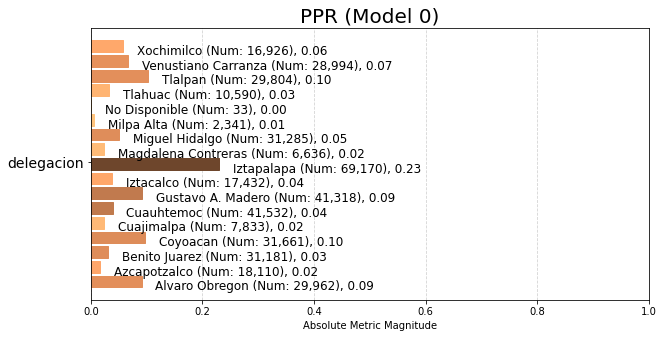

In [41]:
fdr = aeq.plot_group_metric(xtab, 'ppr')

Podemos descubrir que, excepto por Iztapalapa, en general la mayoría de las colonias tienen una proporción baja de predicciones positivas. Esto hace sentido por el hecho de que nuestro realiza muy pocas predicciones positivas. 

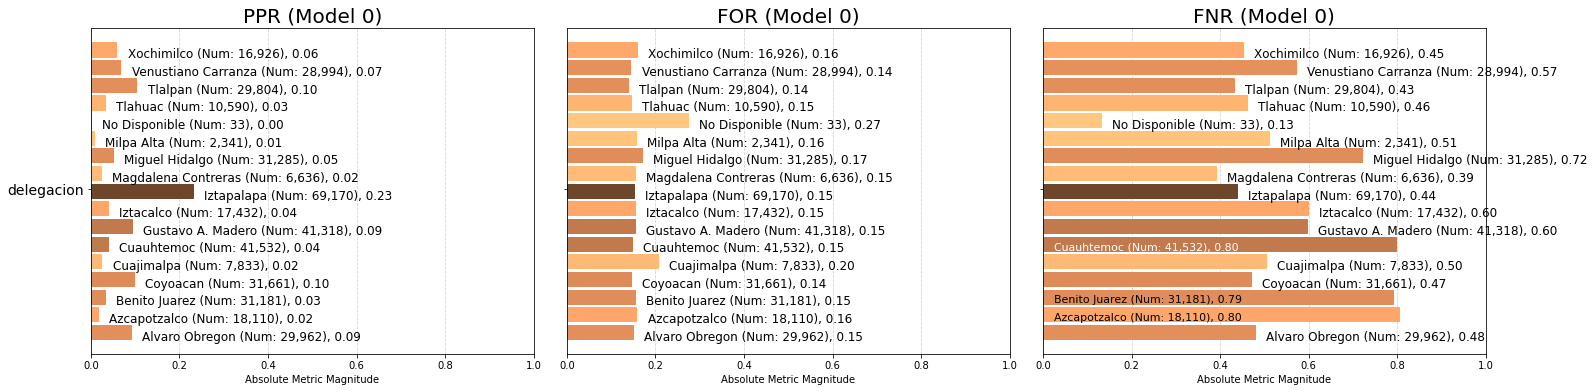

<Figure size 432x288 with 0 Axes>

In [42]:
p = aeq.plot_group_metric_all(xtab, metrics=['ppr','for','fnr'])

Resulta poco claro por qué la _False omission rate_ y la _False negative rate_ son cero en todas las delegaciones. Hemos observado ya en la matriz de confusión que, con este _treshold_ sí existe una cantidad no trivial de falsos negativos. Podemos verlo una vez más. 

In [43]:
pd.DataFrame(confusion_matrix(y_test, new_labels))

,0,1
0,254570,79305
1,45761,35172


### Análisis de Sesgo. 

Pondremos como referencia a Iztalapa por ser la colonia con más predicciones positivas

In [44]:
bias = Bias()

In [45]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df = aeq_df, 
                                ref_groups_dict = {'delegacion': 'Iztapalapa'}, 
                                alpha=0.05)

get_disparity_predefined_group()


In [46]:
bdf[['attribute_name', 'attribute_value'] + bias.list_disparities(bdf)].round(2)
#poner en el html

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,Alvaro Obregon,0.39,0.91,0.98,1.01,0.99,0.91,1.09,0.93,1.05,1.00
1,delegacion,Azcapotzalco,0.07,0.28,1.04,0.98,1.04,0.26,1.84,0.35,1.37,0.99
2,delegacion,Benito Juarez,0.14,0.30,1.01,1.00,1.02,0.28,1.80,0.37,1.36,1.00
3,delegacion,Coyoacan,0.42,0.91,0.97,1.01,0.96,0.91,1.07,0.94,1.04,1.01
4,delegacion,Cuajimalpa,0.10,0.92,1.19,0.91,1.36,0.89,1.15,0.88,1.05,0.94
5,delegacion,Cuauhtemoc,0.17,0.28,0.98,1.01,0.97,0.27,1.82,0.36,1.37,1.01
6,delegacion,Gustavo A. Madero,0.40,0.67,0.97,1.01,1.02,0.66,1.36,0.72,1.17,1.00
7,delegacion,Iztacalco,0.17,0.67,0.95,1.02,1.02,0.66,1.37,0.71,1.17,1.00
8,delegacion,Iztapalapa,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,delegacion,Magdalena Contreras,0.10,1.07,1.11,0.95,1.02,1.04,0.89,1.08,0.98,1.00


Podemos ver que, como era de esperar, prácticamente todas las colonias tienen un _score_ menor que Iztalapa. 

Realizar este análisis es análogo a realizar un análisis por mayoría. Podemos ver que la siguiente tabla es idéntica a la anterior. 

In [47]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=aeq_df)

get_disparity_major_group()


In [48]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,Alvaro Obregon,0.39,0.91,0.98,1.01,0.99,0.91,1.09,0.93,1.05,1.00
1,delegacion,Azcapotzalco,0.07,0.28,1.04,0.98,1.04,0.26,1.84,0.35,1.37,0.99
2,delegacion,Benito Juarez,0.14,0.30,1.01,1.00,1.02,0.28,1.80,0.37,1.36,1.00
3,delegacion,Coyoacan,0.42,0.91,0.97,1.01,0.96,0.91,1.07,0.94,1.04,1.01
4,delegacion,Cuajimalpa,0.10,0.92,1.19,0.91,1.36,0.89,1.15,0.88,1.05,0.94
5,delegacion,Cuauhtemoc,0.17,0.28,0.98,1.01,0.97,0.27,1.82,0.36,1.37,1.01
6,delegacion,Gustavo A. Madero,0.40,0.67,0.97,1.01,1.02,0.66,1.36,0.72,1.17,1.00
7,delegacion,Iztacalco,0.17,0.67,0.95,1.02,1.02,0.66,1.37,0.71,1.17,1.00
8,delegacion,Iztapalapa,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,delegacion,Magdalena Contreras,0.10,1.07,1.11,0.95,1.02,1.04,0.89,1.08,0.98,1.00


Análisis por minoría. Ahora podemos analizar el sesgo a partir de la colonia con _menos_ predicciones positivas. Veamos los resultados. 

In [49]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=aeq_df)

get_disparity_min_metric()


In [50]:
min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,Alvaro Obregon,472.86,3.30,1.11,7.61,1.09,3.52,3.67,2.66,1.08,1.17
1,delegacion,Azcapotzalco,86.50,1.00,1.18,7.42,1.14,1.00,6.16,1.00,1.42,1.16
2,delegacion,Benito Juarez,162.00,1.09,1.14,7.52,1.11,1.10,6.06,1.07,1.40,1.16
3,delegacion,Coyoacan,502.36,3.32,1.10,7.64,1.05,3.54,3.60,2.71,1.08,1.18
4,delegacion,Cuajimalpa,124.64,3.33,1.35,6.88,1.48,3.47,3.86,2.53,1.09,1.09
5,delegacion,Cuauhtemoc,202.59,1.02,1.11,7.62,1.06,1.04,6.12,1.03,1.41,1.17
6,delegacion,Gustavo A. Madero,480.55,2.43,1.10,7.65,1.12,2.57,4.57,2.06,1.21,1.16
7,delegacion,Iztacalco,201.91,2.42,1.08,7.70,1.11,2.57,4.59,2.05,1.21,1.16
8,delegacion,Iztapalapa,1199.59,3.63,1.14,7.54,1.09,3.87,3.36,2.87,1.03,1.17
9,delegacion,Magdalena Contreras,122.95,3.88,1.26,7.17,1.12,4.04,3.00,3.11,1.01,1.16


Podemos ver que, por cualesquiera razones, la colonia Benito Juárez tiene pocas predicciones positivas. 

In [51]:
#función para el script
def bias_(df):
    """
    Function to print bias metrics. 
    :param df: Aequitas-compliant dataframe.  
    """
    bias = Bias()
    bdf = bias.get_disparity_predefined_groups(xtab, original_df = aeq_df, 
                                ref_groups_dict = {'delegacion': 'Iztapalapa'}, 
                                alpha=0.05)
    print("Disparities:")
    print(bdf[['attribute_name', 'attribute_value'] + bias.list_disparities(bdf)].round(2))
    print("Minority Analysis:")
    min_bdf = bias.get_disparity_min_metric(xtab, original_df=aeq_df)
    print(min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2))
    print("Majority Analysis:")
    majority_bdf = bias.get_disparity_major_group(xtab, original_df=aeq_df)
    print(majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2))

In [52]:
#bias_(aeq_df)

#### Visualización de sesgo y disparidad

Solo es posible realizar dos visualizaciones (ppr disparity y pprev_disparity) dado que en el resto de las columnas tenemos valores nulos por las pocas predicciones positivas del modelo. 

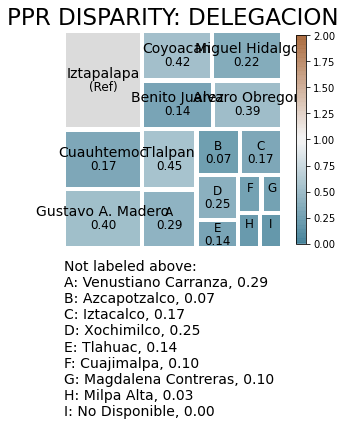

In [53]:
ppr_disparity = aeq.plot_disparity(bdf, group_metric='ppr_disparity', 
                                   attribute_name='delegacion', 
                                   significance_alpha=0.05)

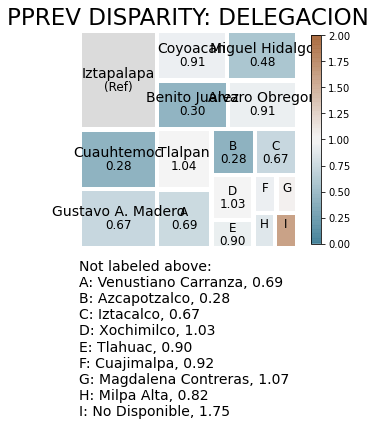

In [54]:
pprev_disparity = aeq.plot_disparity(bdf, group_metric='pprev_disparity', 
                                   attribute_name='delegacion', 
                                   significance_alpha=0.05)

## Análisis de Justicia ( _Fairness_ )

In [55]:
f = Fairness()

In [56]:
fdf = f.get_group_value_fairness(bdf)

In [57]:
parity_determinations = f.list_parities(fdf)

In [58]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,Statistical Parity,FDR Parity,Impact Parity,Precision Parity,FPR Parity,FOR Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,NPV Parity
0,delegacion,Alvaro Obregon,0.52,0.70,0.15,0.69,0.30,0.48,0.85,0.31,...,False,True,True,True,True,True,True,True,False,True
1,delegacion,Azcapotzalco,0.20,0.91,0.16,0.67,0.09,0.80,0.84,0.33,...,False,True,False,True,False,True,False,False,False,True
2,delegacion,Benito Juarez,0.21,0.91,0.15,0.68,0.09,0.79,0.85,0.32,...,False,True,False,True,False,True,False,False,False,True
3,delegacion,Coyoacan,0.53,0.70,0.14,0.69,0.30,0.47,0.86,0.31,...,False,True,True,True,True,True,True,True,False,True
4,delegacion,Cuajimalpa,0.50,0.70,0.20,0.63,0.30,0.50,0.80,0.37,...,False,True,True,True,True,False,False,True,False,True
5,delegacion,Cuauhtemoc,0.20,0.91,0.15,0.69,0.09,0.80,0.85,0.31,...,False,True,False,True,False,True,False,False,False,True
6,delegacion,Gustavo A. Madero,0.40,0.78,0.15,0.70,0.22,0.60,0.85,0.30,...,False,True,False,True,False,True,False,False,False,True
7,delegacion,Iztacalco,0.40,0.78,0.15,0.70,0.22,0.60,0.85,0.30,...,False,True,False,True,False,True,False,False,False,True
8,delegacion,Iztapalapa,0.56,0.67,0.15,0.69,0.33,0.44,0.85,0.31,...,True,True,True,True,True,True,True,True,True,True
9,delegacion,Magdalena Contreras,0.61,0.65,0.15,0.65,0.35,0.39,0.85,0.35,...,False,True,True,True,True,True,True,True,False,True


Podemos ver la equidad a nivel de atributos:

In [59]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


La gran mayoría de las métricas tienen un valor nulo o Falso. 

In [60]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

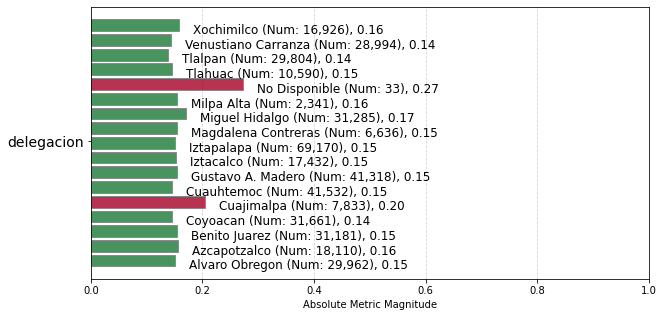

In [61]:
z = aeq.plot_fairness_group(fdf, group_metric='for')

Fue imposible realizar ninguna gráfica debido a que todas las métricas equivalen a cero o tienen valores nulos. El equipo está investigando este problema. 

In [62]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,114477,delegacion,Alvaro Obregon,0.521746,0.697771,0.150110,0.692108,0.302229,...,True,True,True,True,True,True,True,True,False,True
1,0,binary 0/1,114477,delegacion,Azcapotzalco,0.195893,0.914152,0.157031,0.674199,0.085848,...,False,False,False,True,True,False,False,False,False,False
2,0,binary 0/1,114477,delegacion,Benito Juarez,0.209752,0.905572,0.153746,0.683782,0.094428,...,False,False,False,True,True,False,False,False,False,False
3,0,binary 0/1,114477,delegacion,Coyoacan,0.530513,0.696518,0.144840,0.694806,0.303482,...,True,True,True,True,True,True,True,True,False,True
4,0,binary 0/1,114477,delegacion,Cuajimalpa,0.496135,0.702412,0.204871,0.625456,0.297588,...,True,True,True,True,True,True,False,True,False,False
5,0,binary 0/1,114477,delegacion,Cuauhtemoc,0.201709,0.911124,0.146136,0.692843,0.088876,...,False,False,False,True,True,False,False,False,False,False
6,0,binary 0/1,114477,delegacion,Gustavo A. Madero,0.403841,0.779473,0.154459,0.695706,0.220527,...,False,False,True,True,True,False,False,False,False,False
7,0,binary 0/1,114477,delegacion,Iztacalco,0.400722,0.779558,0.153349,0.700135,0.220442,...,False,False,True,True,True,False,False,False,False,False
8,0,binary 0/1,114477,delegacion,Iztapalapa,0.562076,0.667420,0.151055,0.685726,0.332580,...,True,True,True,True,True,True,True,True,True,True
9,0,binary 0/1,114477,delegacion,Magdalena Contreras,0.608387,0.653559,0.154414,0.651386,0.346441,...,True,True,True,True,True,True,True,True,False,True


In [97]:
#todo: la función fairness(df) para el script de python. 